In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import GPy
from scipy.stats import multivariate_normal as mvn
import pandas as pd
import yaml
from typing import Dict
import json

from eqsql import worker_pool, db_tools
from eqsql.task_queues import local_queue

In [2]:
def initial_samples(n=5, grid_size=30, init_id=[]):
    xx = np.linspace(0, 1, grid_size)
    Xgrid = np.array(np.meshgrid(xx, xx)).T.reshape(-1, 2)
    if len(init_id)==0:
        N = Xgrid.shape[0]
        init_id = np.random.choice(N, n, replace=False)
        
    return (Xgrid[init_id], Xgrid)


def to_native(x, lb, ub):
    x_native = np.empty_like(x)
    for i in range(x.shape[1]): 
        x_native[:, i] = lb[i] + x[:, i] * (ub[i] - lb[i])
    return x_native


def TS_npoints(model, npoints, Xgrid, inflate_factor=2):
        
    #' Batch Bayesian optimization using Thompson sampling
    #'
    #' @param model an object of class `hetGP`; e.g., as returned by `mleHetGP`
    #' @param npoints an integer representing the desired number of samples
    #' @param Xgrid a matrix of locations at which the samples are drawn
    #'
    #' @return a matrix containing the `npoints` best locations where next batch of simulations should be run

    pred_mean, pred_cov = model.predict(Xgrid, full_cov=True)
    cov_mtx = 0.5 * (pred_cov + pred_cov.T)
    tTS = mvn.rvs(mean=pred_mean.reshape(-1), cov=cov_mtx, size=npoints * 2)
    best_ids = list(set(np.argmax(tTS, axis=1)))[:npoints]
    return Xgrid[best_ids]


def plot_gp_mean(gp, Xgrid, Xgrid_native, X_native, Y, logged=True, outfile=None, title=None):
    fig, ax = plt.subplots(1,1, figsize = (4, 3))
    
    df = pd.DataFrame(Xgrid_native, columns=['zombie_step_size', 'human_step_size'])
    #df[['zombie_step_size', 'human_step_size']] = df[['zombie_step_size', 'human_step_size']].round(2)
    pred_mean, pred_var = gp.predict(Xgrid)
    
    if logged:
        df['surface'] = np.exp(pred_mean)
    else:
        df['surface'] = pred_mean
            
    # Create the heatmaps
    surface_pivot = df.pivot(index='human_step_size', columns='zombie_step_size', values='surface').sort_index(ascending=False)
    
    surface_pivot.index = surface_pivot.index.round(3)
    surface_pivot.columns = surface_pivot.columns.round(3)
    X_native = X_native.round(3)
    
    # Transform scatter point coordinates to match heatmap's grid
    # Mapping the real 'human_step_size' and 'zombie_step_size' to the heatmap's row and column indices
    human_indices = pd.Series(X_native[:, 1]).map({value: idx for idx, value in enumerate(surface_pivot.index)})
    zombie_indices = pd.Series(X_native[:, 0]).map({value: idx for idx, value in enumerate(surface_pivot.columns)})
    
    surface_pivot.index = surface_pivot.index.round(1)
    surface_pivot.columns = surface_pivot.columns.round(1)
    
    sns.heatmap(surface_pivot, ax=ax, cmap='Blues', vmin=100, vmax=3900)
        # Set limits with a small margin
    # add smaller buffer
    margin_size = .5  # Adjust margin size as needed
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.set_xlim([xlim[0] - margin_size, xlim[1] + margin_size])
    ax.set_ylim([ylim[0] + margin_size, ylim[1] - margin_size])
    
    xlabels = [label if i % 2 == 0 else '' for i, label in enumerate(ax.get_xticklabels())]
    ax.set_xticklabels(xlabels)
    
    # For y-axis
    ylabels = [label if i % 2 == 0 else '' for i, label in enumerate(ax.get_yticklabels())]
    ax.set_yticklabels(ylabels)
    
    ax.set_xlabel('Zombie Step Size')
    ax.set_ylabel('Human Step Size')
    if title is not None:
        plt.title(title)
    
    # Plot scatter points with adjusted coordinates
    ax.scatter(zombie_indices+.5, human_indices+.5, edgecolors='black', c=np.exp(Y), cmap='Blues', vmin=100, vmax=3900)
    
    if outfile is not None:
        plt.savefig(outfile, dpi=300, bbox_inches='tight')
    plt.show()

In [11]:
def run(exp_id: str, params: Dict):

    db_started = False
    pool = None
    task_queue = None

    try:
        # start database
        db_tools.start_db(params['db_path'], pg_bin_path=params['pg_bin_path'])
        db_started = True

        # start local task queue
        task_queue = local_queue.init_task_queue(params['db_host'], params['db_user'],
                                                    port=None, db_name=params['db_name'])

        # check if the input and output queues are empty,
        # if not, then exit with a warning.
        if not task_queue.are_queues_empty():
            print("WARNING: db input / output queues are not empty. Aborting run", flush=True)
            task_queue.clear_queues()
            return

        # start worker pool
        pool_params = worker_pool.cfg_file_to_dict(params['pool_cfg_file'])
        pool = worker_pool.start_local_pool(params['worker_pool_id'], params['pool_launch_script'],
                                            exp_id, pool_params)
        task_type = params['task_type']

        init_ids = [217, 233, 465, 697, 713]
        X, Xgrid = initial_samples(init_id=init_ids)
        Xgrid_native = to_native(Xgrid, lb=np.array([0.1, 1]), ub=np.array([1, 3]))
        Xnative = to_native(X, lb=np.array([0.1, 1]), ub=np.array([1, 3]))
        
        payloads = list(map(lambda a: json.dumps(list(a)), Xnative))
        _, fts = task_queue.submit_tasks(exp_id, task_type, payloads)

        sorted_fts = sorted(task_queue.as_completed(fts), key=lambda ft: ft.eq_task_id)
        Y = np.array([json.loads(ft.result()[1]) for ft in sorted_fts])

        # logging response for numerical stability
        Y = np.log(Y)

        # keep track of best 
        f_best = []
        X_best = np.empty((0, 2))

        f_best.append(np.exp(np.max(Y)))
        X_best = np.vstack([X_best, X[np.argmax(Y)]])
        
        native_best = to_native(X_best, lb=np.array([0.1, 1]), ub=np.array([1, 3]))
        print(f">> iter = 0: current best value = {f_best[0]} at zombie_step_size = {native_best[0, 0]}, human_step_size = {native_best[0, 1]}")

        # fit GP on logged response
        gp = GPy.models.GPRegression(X, Y.reshape(-1,1))
        gp.optimize()

        # plot initial fit/design
        plot_gp_mean(gp, Xgrid, Xgrid_native, Xnative, Y, title='Initial design')

        n_steps = params['n_steps']
        n_points = params['n_points']

        for i in np.arange(1, n_steps + 1):
            X_new = TS_npoints(model = gp, npoints = n_points, Xgrid = Xgrid)
            X_new_native = to_native(X_new, lb= np.array([0.1, 1]), ub=np.array([1, 3]))
            payloads = list(map(lambda a: json.dumps(list(a)), X_new_native))
            _, fts = task_queue.submit_tasks(exp_id, task_type, payloads)
            sorted_fts = sorted(task_queue.as_completed(fts), key=lambda ft: ft.eq_task_id)
            Y_new = np.array([json.loads(ft.result()[1]) for ft in sorted_fts])

            # log for numerical stability
            Y_new = np.log(Y_new)
            
            # append to existing best
            X = np.vstack([gp.X, X_new])
            Xnative = to_native(X, lb=np.array([0.1, 1]), ub=np.array([1, 3]))
            Y = np.vstack([gp.Y, Y_new.reshape(-1,1)])

            # update GP with new data
            #gp.set_XY(X, Y)
            gp = GPy.models.GPRegression(X, Y)
            gp.optimize()

            best_ix = np.argmax(Y)
            f_best.append(np.exp(Y[best_ix][0]))
            X_best = np.vstack([X_best, X[best_ix]])

            plot_gp_mean(gp, Xgrid, Xgrid_native, Xnative, Y, title=f'TS iteration {i}')
            
            native_best = to_native(X_best, lb=np.array([0.1, 1]), ub=np.array([1, 3]))
            print(f">> iter = {i}: current best value = {f_best[i]} at zombie_step_size = {native_best[i, 0]}, human_step_size = {native_best[i, 1]}")

        # # Plot sequential trajectory
        # clist = ['red']*n1 + ['navy']*(X.shape[0]-n1)
        # alist = [1]*n1 + list(np.linspace(.1, 1, X.shape[0]-n1))
                            
        # plt.scatter(X[:,0], X[:,1], alpha=alist, c=clist)
        # plt.show()

        return (X, Y)
                    

    finally:
        if task_queue is not None:
            task_queue.close()
        if pool is not None:
            pool.cancel()
        if db_started:
            db_tools.stop_db(params['db_path'])

Checking for pg_ctl ...
/home/nick/miniconda3/envs/emews-py3.10/bin/pg_ctl


Starting database with log:/home/nick/Documents/db/wsc_tutorial/db.log
Database server started
>> iter = 0: current best value = 2210.1999999999994 at zombie_step_size = 0.3172413793103448, human_step_size = 1.4827586206896552


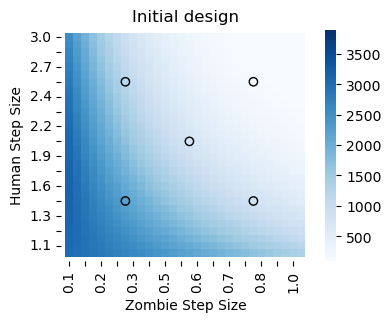

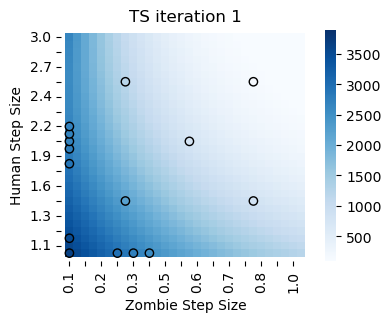

>> iter = 1: current best value = 3656.3999999999983 at zombie_step_size = 0.1, human_step_size = 1.0


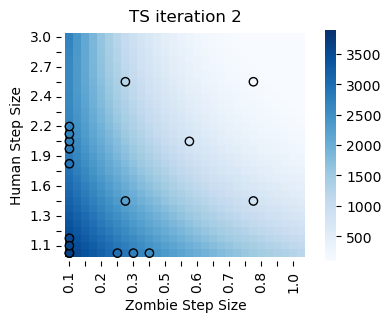

>> iter = 2: current best value = 3656.3999999999983 at zombie_step_size = 0.1, human_step_size = 1.0


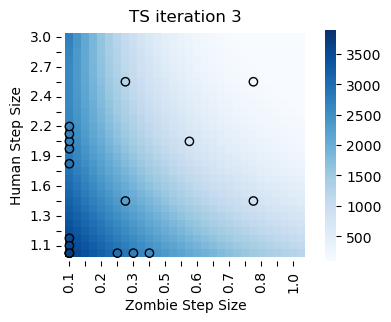

>> iter = 3: current best value = 3656.3999999999983 at zombie_step_size = 0.1, human_step_size = 1.0


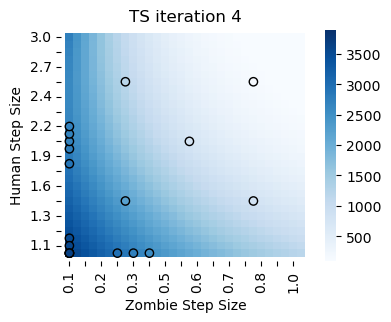

>> iter = 4: current best value = 3656.3999999999983 at zombie_step_size = 0.1, human_step_size = 1.0
Checking for pg_ctl ...
/home/nick/miniconda3/envs/emews-py3.10/bin/pg_ctl


Stopping database server

waiting for server to shut down.... done
server stopped



In [12]:
from eqsql import cfg
config_file = "./algo_cfg.yaml"
params = cfg.parse_yaml_cfg(config_file)
X, Y = run('t1', params)